In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [42]:
from sklearn.model_selection import RandomizedSearchCV as RSCV
import xgboost as xgb

In [2]:
pd.set_option("max_rows", 25)
# Apply the default theme
sns.set_theme()
sns.set_style("whitegrid")

In [3]:
data_path = '/home/achara/data/achara/'
df = pd.read_csv(data_path + 'pc_data_2017_to_2019_2.csv')

## Feature scaling

In [4]:
df.columns

Index(['DateTime', 'SensorDepth_Water_EXO', 'PC_Water_EXO', 'Chla_Water_EXO',
       'DO_Water_EXO', 'DO-Sat_Water_EXO', 'SpCond_Water_EXO',
       'Temperature_Water_EXO', 'pH_Water_EXO', 'rel_fl', 'month', 'day',
       'year', 'SolarRad_Air_LiCor', 'TP', 'TSP', 'SRP', 'TN', 'NO3', 'NH4',
       'PP', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_LW_DWN'],
      dtype='object')

In [5]:
variables = ['SensorDepth_Water_EXO', 'PC_Water_EXO', 'Chla_Water_EXO',
             'DO_Water_EXO', 'DO-Sat_Water_EXO', 'SpCond_Water_EXO',
             'Temperature_Water_EXO', 'pH_Water_EXO', 'rel_fl', 'SolarRad_Air_LiCor', 'TP', 'TSP', 'SRP', 'TN', 'NO3',
             'NH4',
             'PP', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_LW_DWN']

In [6]:
df_filtered = df[variables]

In [7]:
features = ['SensorDepth_Water_EXO', 'Chla_Water_EXO',
            'DO_Water_EXO', 'DO-Sat_Water_EXO', 'SpCond_Water_EXO',
            'Temperature_Water_EXO', 'pH_Water_EXO', 'rel_fl', 'SolarRad_Air_LiCor', 'TP', 'TSP', 'SRP', 'TN', 'NO3',
            'NH4',
            'PP', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_LW_DWN']

## Splitting into train and test data

In [8]:
n_rows = len(df)
train_size_percent = 0.8
train_size = round(train_size_percent * n_rows)
test_size = n_rows - train_size

In [9]:
train_df, test_df = train_test_split(df, train_size=train_size, test_size=test_size)

In [10]:
train_x = train_df[features]
train_y = train_df.PC_Water_EXO

test_x = test_df[features]
test_y = test_df.PC_Water_EXO

## Feature selection using Recursive Feature Extraction:

In [11]:
from sklearn.feature_selection import RFE

In [49]:
from operator import itemgetter
from sklearn.metrics import mean_absolute_error

In [12]:
rf = RandomForestRegressor(max_depth=9, max_features=0.8, max_samples=0.5,
                           n_estimators=185)

In [13]:
rfe = RFE(estimator=rf, n_features_to_select=1)

In [14]:
rfe.fit(train_x, train_y)

RFE(estimator=RandomForestRegressor(max_depth=9, max_features=0.8,
                                    max_samples=0.5, n_estimators=185),
    n_features_to_select=1)

In [16]:
for x, y in (sorted(zip(rfe.ranking_, features), key=itemgetter(0))):
    print(x, y)

1 rel_fl
2 SpCond_Water_EXO
3 Temperature_Water_EXO
4 NO3
5 SolarRad_Air_LiCor
6 TSP
7 DO_Water_EXO
8 SRP
9 SensorDepth_Water_EXO
10 Chla_Water_EXO
11 pH_Water_EXO
12 TN
13 TP
14 DO-Sat_Water_EXO
15 PP
16 NH4
17 ALLSKY_SFC_SW_DWN
18 ALLSKY_SFC_LW_DWN
19 PRECTOTCORR


In [17]:
train_x_scaled = MinMaxScaler().fit_transform(train_x)

In [18]:
rfe.fit(train_x_scaled, train_y)

RFE(estimator=RandomForestRegressor(max_depth=9, max_features=0.8,
                                    max_samples=0.5, n_estimators=185),
    n_features_to_select=1)

In [19]:
for x, y in (sorted(zip(rfe.ranking_, features), key=itemgetter(0))):
    print(x, y)

1 rel_fl
2 SpCond_Water_EXO
3 Temperature_Water_EXO
4 NO3
5 SolarRad_Air_LiCor
6 TSP
7 DO_Water_EXO
8 TN
9 pH_Water_EXO
10 Chla_Water_EXO
11 SensorDepth_Water_EXO
12 SRP
13 TP
14 DO-Sat_Water_EXO
15 PP
16 NH4
17 ALLSKY_SFC_SW_DWN
18 ALLSKY_SFC_LW_DWN
19 PRECTOTCORR


In [30]:
best_features = [y for x, y in list(sorted(zip(rfe.ranking_, features), key=itemgetter(0))) if x <= 11]

In [31]:
best_features

['rel_fl',
 'SpCond_Water_EXO',
 'Temperature_Water_EXO',
 'NO3',
 'SolarRad_Air_LiCor',
 'TSP',
 'DO_Water_EXO',
 'TN',
 'pH_Water_EXO',
 'Chla_Water_EXO',
 'SensorDepth_Water_EXO']

In [34]:
xgb_reg = xgb.XGBRegressor(eval_metric='rmsle')

In [35]:
param_grid = {"max_depth": [5, 7, 9],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015, 0.1]}

In [39]:
train_x_scaled_filtered = MinMaxScaler().fit_transform(train_x[best_features])

In [43]:
search = RSCV(xgb_reg, param_grid, cv=5).fit(train_x_scaled_filtered, train_y)

In [44]:
search.best_score_

0.9705627225177761

In [45]:
search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmsle', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=9, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=600, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [46]:
test_x_scaled_filtered = MinMaxScaler().fit_transform(test_x[best_features])

In [47]:
best_rgb = search.best_estimator_

In [48]:
y_pred = best_rgb.predict(test_x_scaled_filtered)

In [53]:
mae = mean_absolute_error(test_y, y_pred)
print(mae)

0.05741217398438248


In [52]:
1 - mae

0.9425878260156175

In [55]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

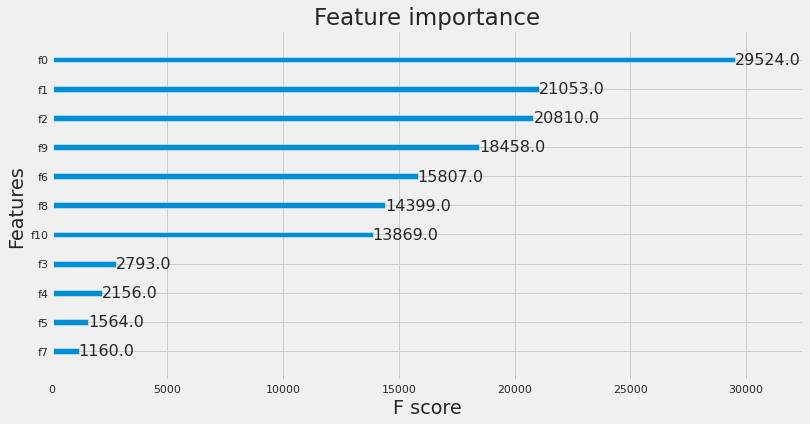

In [58]:
fig, ax = plt.subplots(figsize=(12,6))
plot_importance(best_rgb, ax=ax)
plt.show();

In [59]:
feature_ranks = [0,1,2,9,6,8,10,3,4,5,7]

In [63]:
ranked_best_features = [best_features[i] for i in feature_ranks]
rank = 1
for i in ranked_best_features:
    print(rank, i)
    rank+=1

1 rel_fl
2 SpCond_Water_EXO
3 Temperature_Water_EXO
4 Chla_Water_EXO
5 DO_Water_EXO
6 pH_Water_EXO
7 SensorDepth_Water_EXO
8 NO3
9 SolarRad_Air_LiCor
10 TSP
11 TN


## Conclusion

The best score was achieved using Extreme Gradient Boosting on the following features:


1 rel_fl
2 SpCond_Water_EXO
3 Temperature_Water_EXO
4 Chla_Water_EXO
5 DO_Water_EXO
6 pH_Water_EXO
7 SensorDepth_Water_EXO
8 NO3
9 SolarRad_Air_LiCor
10 TSP
11 TN